In [32]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix


from sklearn.calibration import CalibratedClassifierCV


This part is to read the cleaned data and check if there is NAN data or Infinite data.

In [6]:
data = 'cell2celltrain_clean_updated_final.csv'
data = pd.read_csv(data)
feature = data.iloc[:, 2:]
label = data.iloc[:, 1]
print(np.any(np.isnan(feature))) #and gets True
print(np.all(np.isfinite(feature))) #and gets True
print(data.shape)

False
True
(49752, 75)


After checking the data, we apply PCA algorithm into the model to get the features that count more variance. For those features, we transform them into the PCA form and use the values directly to do the following machine learning methods.

In [7]:
pca = PCA(n_components=20)
pca.fit(feature)
X_new = pca.fit_transform(feature)
print(np.cumsum(pca.explained_variance_ratio_)[-1])

0.8409716652569876


We split the data into PCA form data and normal data. We use 30% samples for testing and 70% for training. For the normal data, there are 73 features and for the PCA form data, there are 20 features.

In [8]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
     X_new, label, test_size=0.3)
X_train, X_test, y_train, y_test = train_test_split(
     feature, label, test_size=0.3)
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', y_test.shape)

X train shape:  (34826, 73)
Y train shape:  (34826,)
X test shape:  (14926, 73)
Y test shape:  (14926,)


Firstly, we try the Random Forest Classifier. A Random Forest Classifier is an ensemble learning method used for both classification and regression tasks. It works in the following ways:
1. Ensemble of Decision Trees: This model has sets of decision trees. They are trained independently.
2. Random Subsampling of Features: During the construction of each tree, a random subset of features is considered at each split. This decorrelates the trees and makes the ensemble more robust.
3. Voting or Averaging: The predictions of individual trees are combined through a voting mechanism, where the class that receives the most votes becomes the final prediction. For regression tasks, the predictions are averaged.

0.7181428380008039


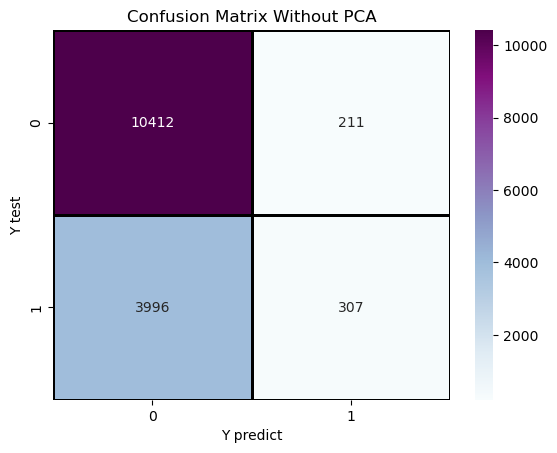

In [36]:
# random forest classifier

# without pca
model1 = RandomForestClassifier(n_estimators=100,random_state=9,n_jobs=-1)
model1.fit(X_train, y_train)
y_scores = model1.predict(X_test)
score = model1.score(X_test, y_test)
print(score)
matrix = confusion_matrix(y_test, y_scores)
f, ax = plt.subplots()
sns.heatmap(matrix, annot=True, linewidth=0.75, linecolor='black', fmt='g', ax=ax, cmap="BuPu")
plt.title('Confusion Matrix Without PCA')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

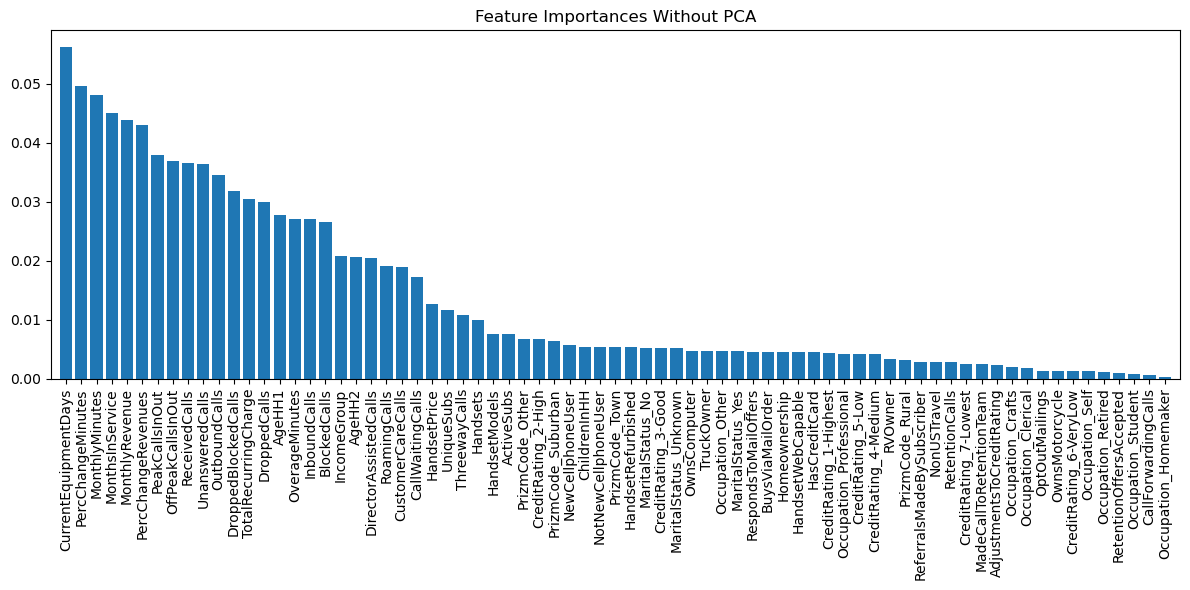

In [39]:

feature_names = X_train.columns


feature_importances = model1.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances Without PCA')

plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align='center')

plt.xticks(range(X_train.shape[1]), feature_names[sorted_indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

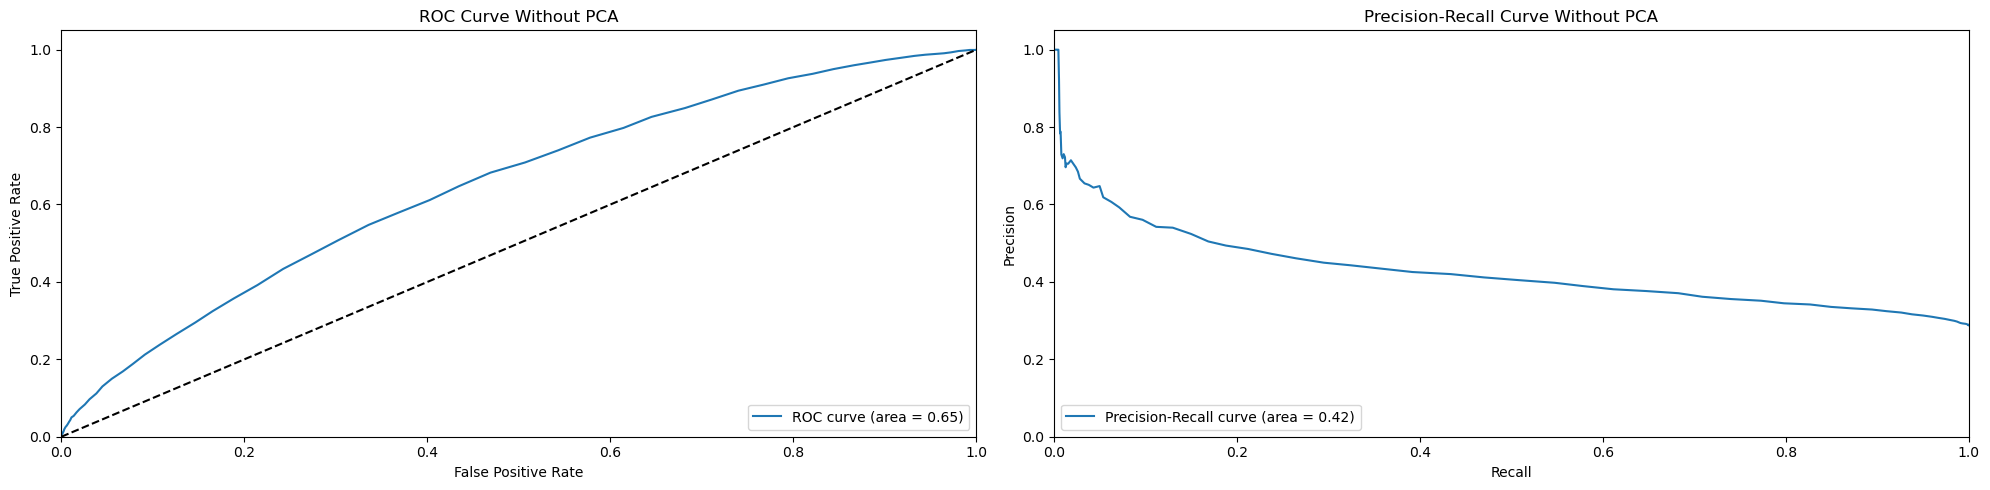

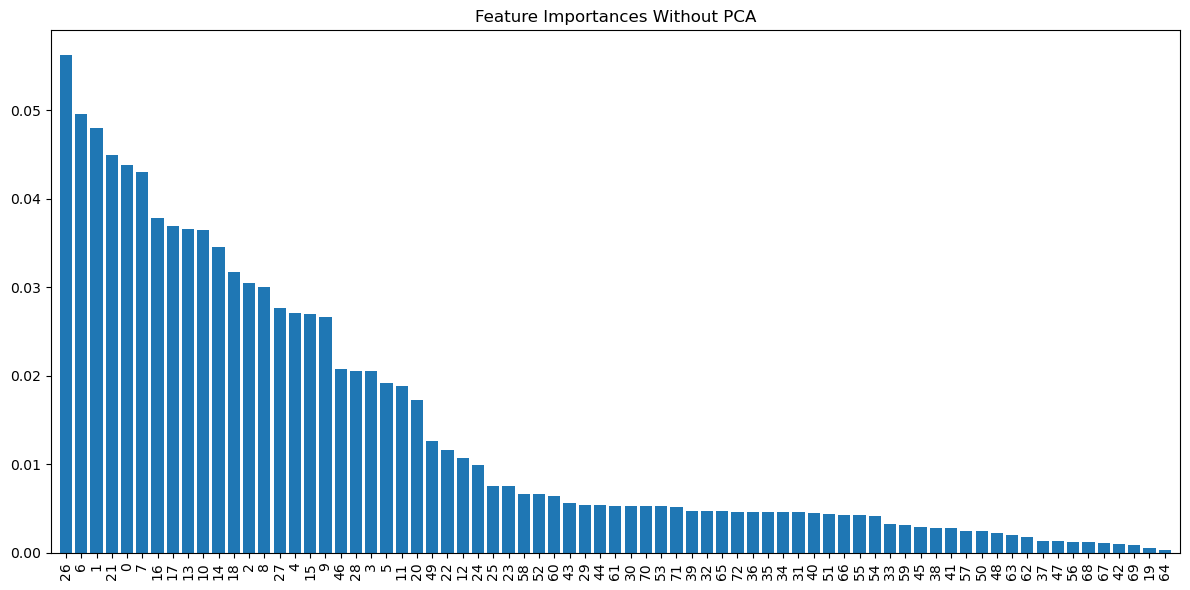

In [38]:
#PLOTS
#ROC
y_pred_proba = model1.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)



#precision recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)


plt.figure(figsize=(20, 5))  


plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Without PCA')
plt.legend(loc="lower right")


plt.subplot(1, 2, 2)  
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve Without PCA')
plt.legend(loc="lower left")

#show
plt.tight_layout()
plt.show()


#feature importances
feature_importances = model1.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances Without PCA')
plt.bar(range(X_train.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), indices, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

For this confusion matrix, TP is 10404, FP is 248, FN is 3929, TN is 345. Thus, multiple evaluation methods are determined:
1. Recall=0.726
2. Precision=0.977
3. Accuracy=0.720
4. f=0.833


0.7137880209031221


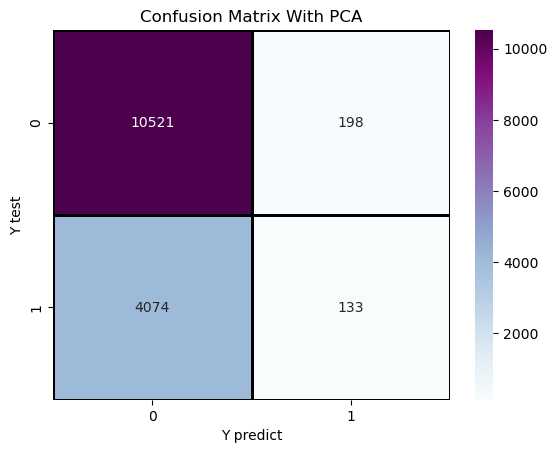

In [14]:
# random forest classifier

# with pca
model2 = RandomForestClassifier(n_estimators=100,random_state=9,n_jobs=-1)
model2.fit(X_train_pca, y_train_pca)
y_scores = model2.predict(X_test_pca)
score = model2.score(X_test_pca, y_test_pca)
print(score)
cm = confusion_matrix(y_test_pca, y_scores)
f, ax = plt.subplots()
sns.heatmap(cm, annot=True, linewidth=0.75, linecolor='black', fmt='g', ax=ax, cmap="BuPu")
plt.title('Confusion Matrix With PCA')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

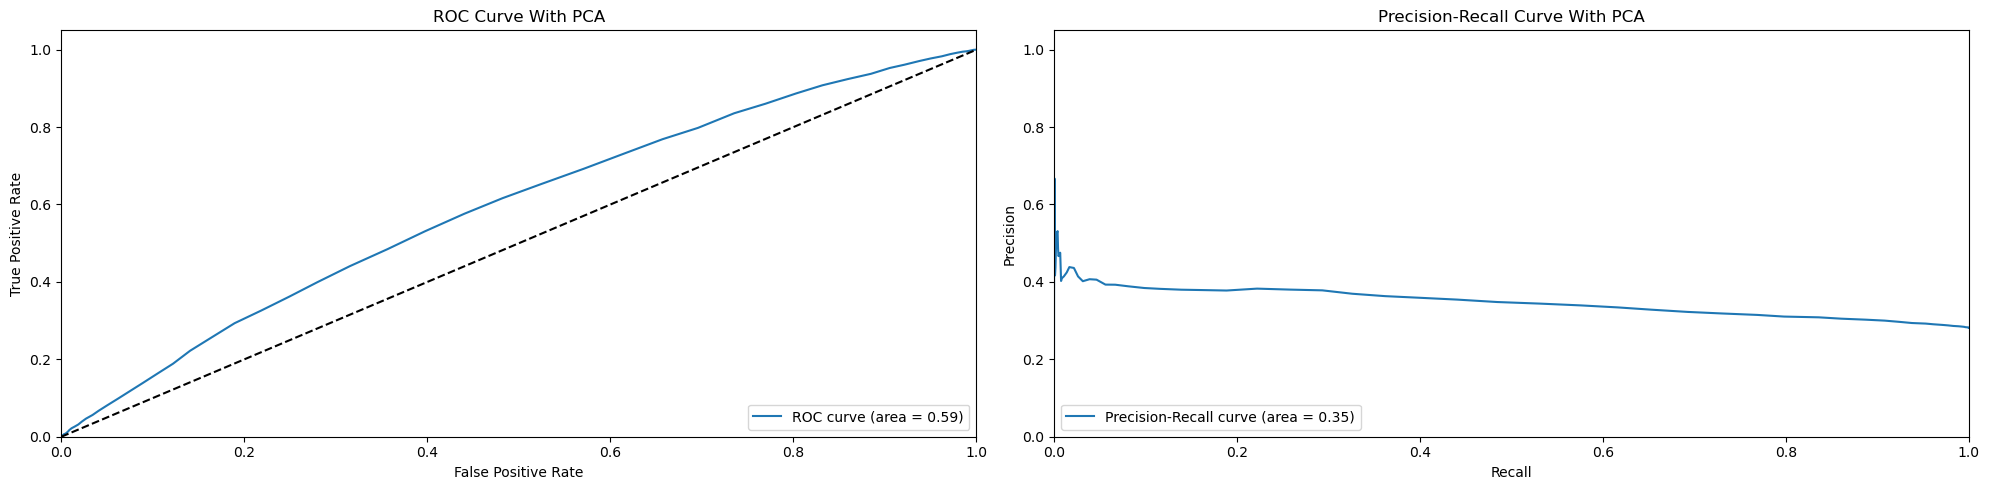

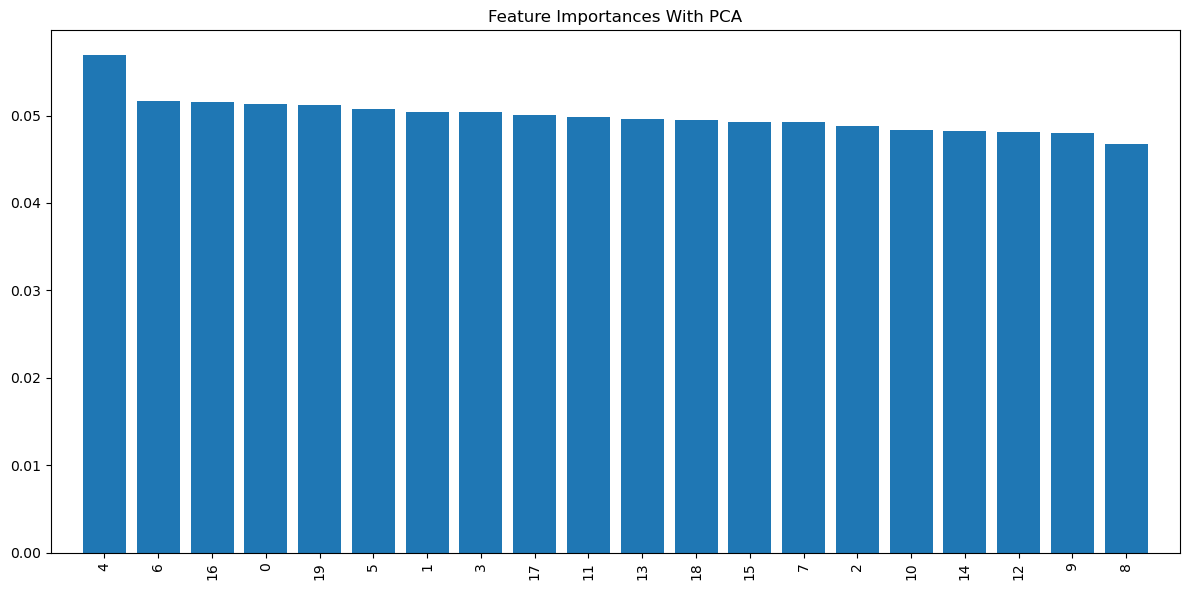

In [30]:
#ROC
y_pred_proba_pca = model2.predict_proba(X_test_pca)[:, 1]
fpr_pca, tpr_pca, thresholds_pca = roc_curve(y_test_pca, y_pred_proba_pca)
roc_auc_pca = auc(fpr_pca, tpr_pca)



#PR
precision_pca, recall_pca, _ = precision_recall_curve(y_test_pca, y_pred_proba_pca)
average_precision_pca = average_precision_score(y_test_pca, y_pred_proba_pca)



plt.figure(figsize=(20, 5))  


plt.subplot(1, 2, 1)  
plt.plot(fpr_pca, tpr_pca, label='ROC curve (area = %0.2f)' % roc_auc_pca)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve With PCA')
plt.legend(loc="lower right")


plt.subplot(1, 2, 2)  
plt.plot(recall_pca, precision_pca, label='Precision-Recall curve (area = %0.2f)' % average_precision_pca)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve With PCA')
plt.legend(loc="lower left")

#show
plt.tight_layout()
plt.show()




importances_pca = model2.feature_importances_
indices_pca = np.argsort(importances_pca)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances With PCA')
plt.bar(range(X_train_pca.shape[1]), importances_pca[indices_pca], align='center')
plt.xticks(range(X_train_pca.shape[1]), indices_pca, rotation=90)
plt.xlim([-1, X_train_pca.shape[1]])
plt.tight_layout()
plt.show()

Results show that without PCA, random forest classifier has 0.4% accuracy higher than the one use PCA form.


In the following two codes, we use logistic regression. For this binary classification problem, the model follows these steps:
1. Use linear combination model of the features: $z=b_0 + b_1x_1 + b_2x_2 \cdot\cdot\cdot + b_nx_n$
2. Put them into Sigmoid function $f(z) = \frac{1}{1 + e^{-z}}$
3. Maximum Likelihood Estimation Optimization. The goal is to find the set of weights and bias that maximizes the likelihood of the observed outcomes given the input features.

C:\Users\Shreya\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7121130912501675


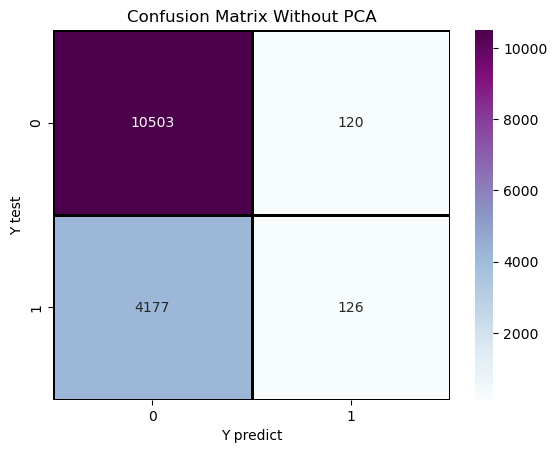

In [25]:
# logistic regression

# without pca
log_r = LogisticRegression(random_state=0).fit(X_train, y_train)
y_scores = log_r.predict(X_test)
results_naive = log_r.score(X_test, y_test)
print(results_naive)

cm = confusion_matrix(y_test, y_scores)
f, ax = plt.subplots()
sns.heatmap(cm, annot=True, linewidth=0.75, linecolor='black', fmt='g', ax=ax, cmap="BuPu")
plt.title('Confusion Matrix Without PCA')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()


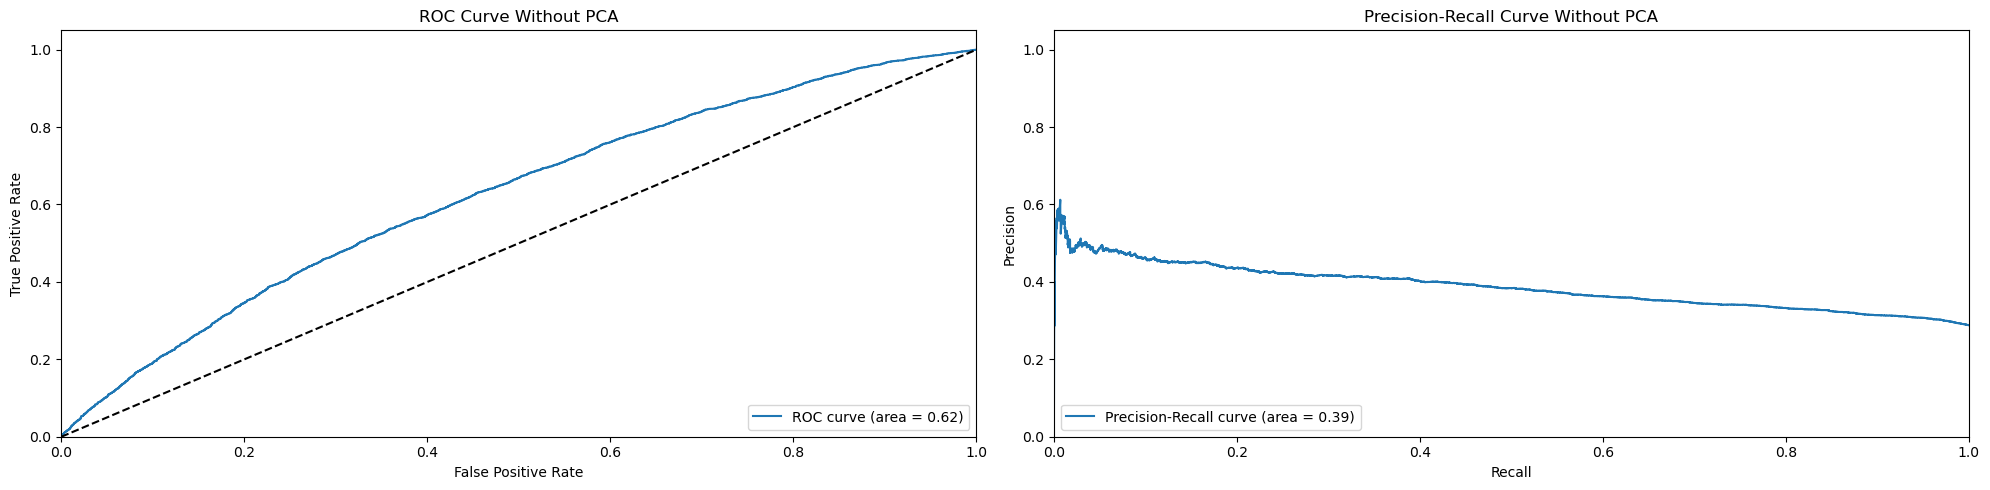

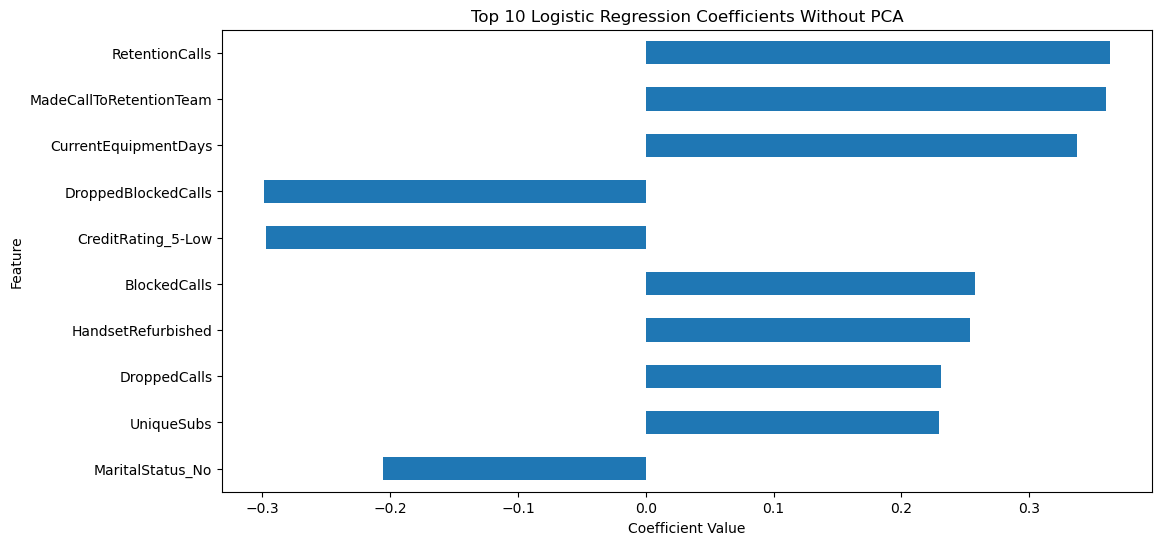

In [26]:
#ROC
y_pred_proba_log = log_r.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_pred_proba_log)
roc_auc_log = auc(fpr_log, tpr_log)



#Precision recall
precision_log, recall_log, _ = precision_recall_curve(y_test, y_pred_proba_log)
average_precision_log = average_precision_score(y_test, y_pred_proba_log)


plt.figure(figsize=(20, 5))  

plt.subplot(1, 2, 1)  
plt.plot(fpr_log, tpr_log, label='ROC curve (area = %0.2f)' % roc_auc_log)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Without PCA')
plt.legend(loc="lower right")


plt.subplot(1, 2, 2)  
plt.plot(recall_log, precision_log, label='Precision-Recall curve (area = %0.2f)' % average_precision_log)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve Without PCA')
plt.legend(loc="lower left")

#show
plt.tight_layout()
plt.show()

#Coefficients as Feature Importance- we use top 10
plt.figure(figsize=(12, 6))
coefficients = log_r.coef_.ravel()
feature_importance = pd.Series(coefficients, index=X_train.columns).sort_values(key=abs)
feature_importance.tail(10).plot(kind='barh')  
plt.title('Top 10 Logistic Regression Coefficients Without PCA')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


0.717070883022913


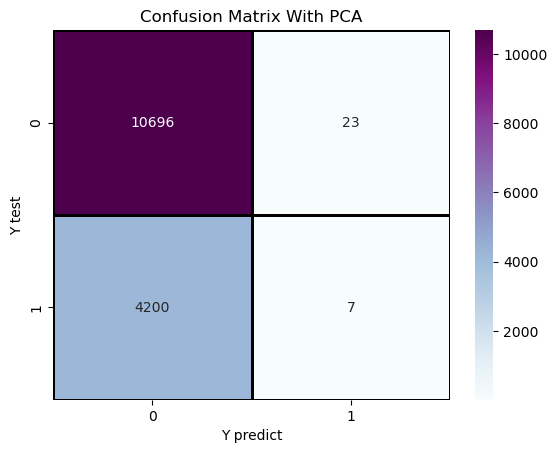

In [21]:
# with pca
log_r = LogisticRegression(random_state=0).fit(X_train_pca, y_train_pca)
y_scores = log_r.predict(X_test_pca)
results_pca = log_r.score(X_test_pca, y_test_pca)
print(results_pca)

cm = confusion_matrix(y_test_pca, y_scores)
f, ax = plt.subplots()
sns.heatmap(cm, annot=True, linewidth=0.75, linecolor='black', fmt='g', ax=ax, cmap="BuPu")
plt.title('Confusion Matrix With PCA')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

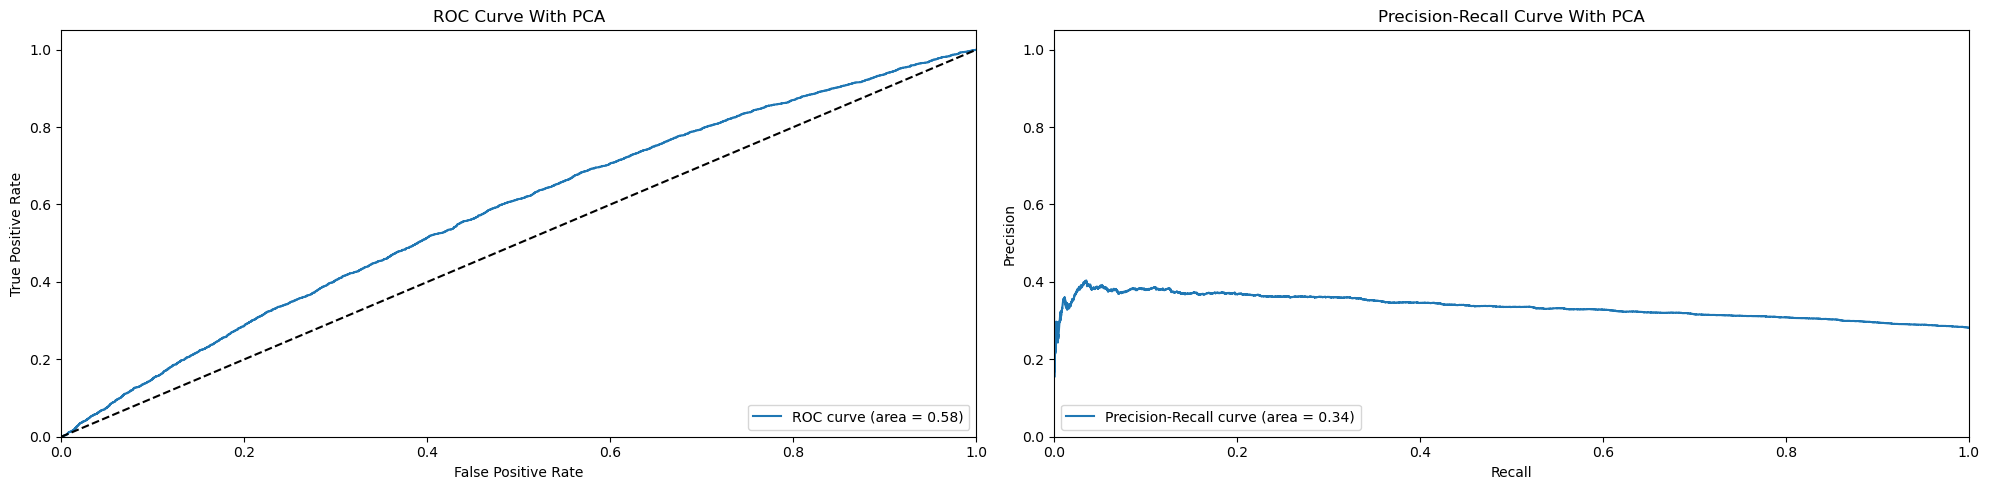

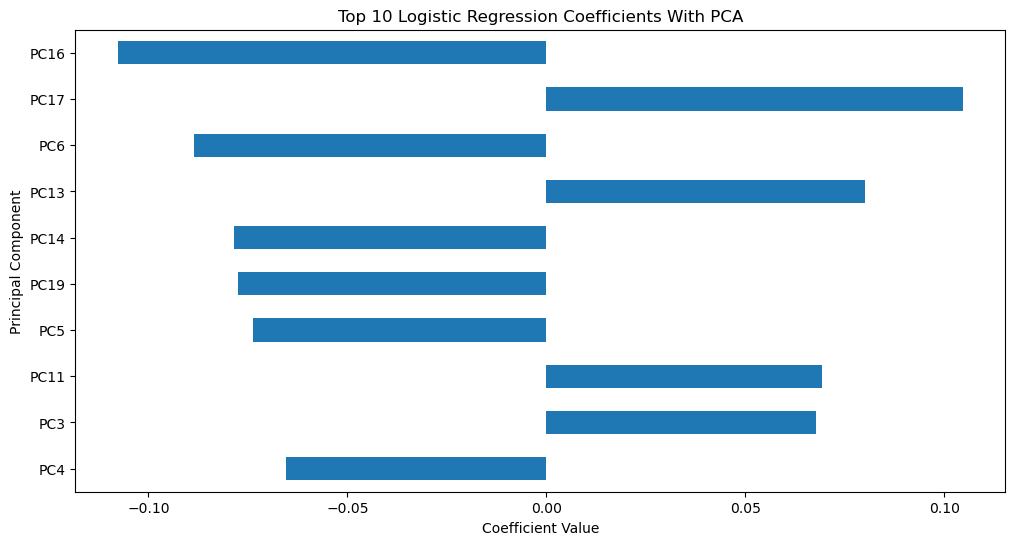

In [23]:
#PLOTS
#roc
y_pred_proba_pca_log = log_r.predict_proba(X_test_pca)[:, 1]
fpr_log_pca, tpr_log_pca, thresholds_log_pca = roc_curve(y_test_pca, y_pred_proba_pca_log)
roc_auc_log_pca = auc(fpr_log_pca, tpr_log_pca)


#PR
precision_log_pca, recall_log_pca, _ = precision_recall_curve(y_test_pca, y_pred_proba_pca_log)
average_precision_log_pca = average_precision_score(y_test_pca, y_pred_proba_pca_log)


plt.figure(figsize=(20, 5))  


plt.subplot(1, 2, 1)  
plt.plot(fpr_log_pca, tpr_log_pca, label='ROC curve (area = %0.2f)' % roc_auc_log_pca)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve With PCA')
plt.legend(loc="lower right")


plt.subplot(1, 2, 2)  
plt.plot(recall_log_pca, precision_log_pca, label='Precision-Recall curve (area = %0.2f)' % average_precision_log_pca)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve With PCA')
plt.legend(loc="lower left")

#show
plt.tight_layout()
plt.show()



#coeffs as feature imp (principal components)
plt.figure(figsize=(12, 6))
coefficients_pca = log_r.coef_.ravel()
feature_importance_pca = pd.Series(coefficients_pca, index=['PC' + str(i) for i in range(len(coefficients_pca))])
feature_importance_pca.sort_values(key=abs).tail(10).plot(kind='barh')  # Tail to get the 10 most significant components
plt.title('Top 10 Logistic Regression Coefficients With PCA')
plt.xlabel('Coefficient Value')
plt.ylabel('Principal Component')
plt.show()

Results show that without PCA, logistic classifier has 0.3% accuracy lower than the one use PCA form

SVMs are particularly effective in high-dimensional spaces and are well-suited for situations where the data is not linearly separable. This method is to optimize the following objective function:
$$\text{Maximize } \frac{1}{2} \|w\|^2 - C \sum_{i=1}^{N} \xi_i$$
With constraints:
$$y_i (w^T x_i + b) \geq 1 - \xi_i, \quad \text{for } i = 1, 2, \ldots, N$$
$$\xi_i \geq 0
$$
Where
$w$ are weights.
$C$ is the regularization parameter.
$\xi_i$ are slack variables.

with pca AP:0.7180088436285677


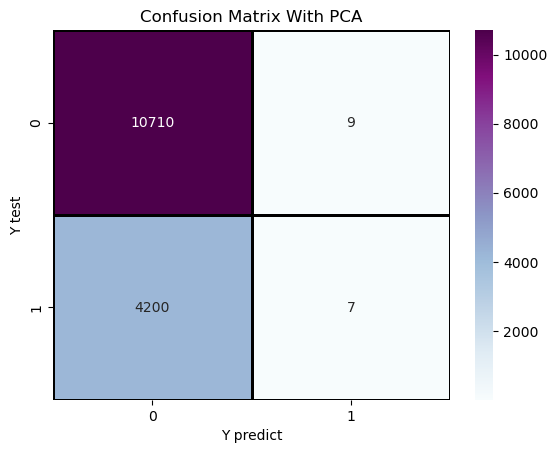

In [31]:
# support vector machines

# with pca
svm_cls_pca = svm.SVC()
svm_cls_pca.fit(X_train_pca, y_train_pca)
y_scores = svm_cls_pca.predict(X_test_pca)
pca_AP = svm_cls_pca.score(X_test_pca, y_test_pca)
print('with pca AP:{}'.format(pca_AP))
cm = confusion_matrix(y_test_pca, y_scores)
f, ax = plt.subplots()
sns.heatmap(cm, annot=True, linewidth=0.75, linecolor='black', fmt='g', ax=ax, cmap="BuPu")
plt.title('Confusion Matrix With PCA')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

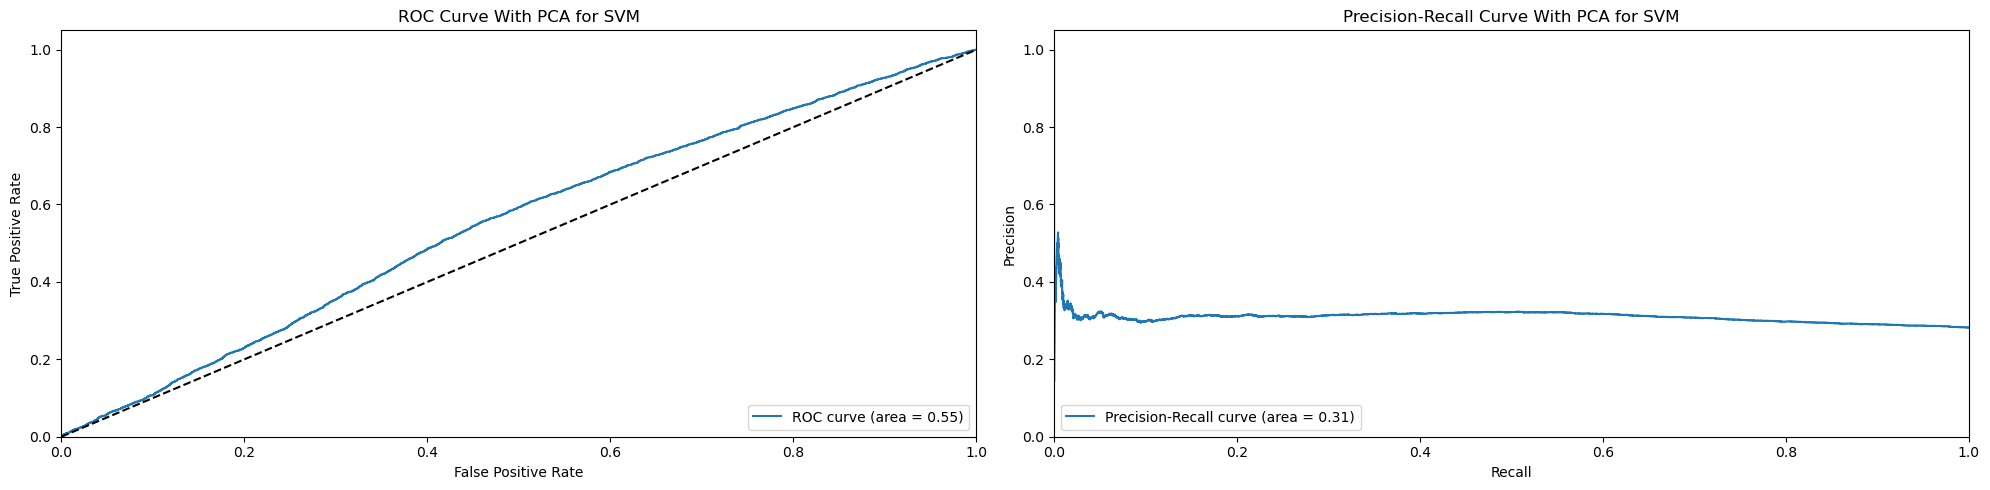

In [33]:
#calibrate
svm_calibrated = CalibratedClassifierCV(svm_cls_pca, cv='prefit')
svm_calibrated.fit(X_train_pca, y_train_pca)


y_scores_pca = svm_calibrated.predict_proba(X_test_pca)[:, 1]


fpr_pca, tpr_pca, _ = roc_curve(y_test_pca, y_scores_pca)
roc_auc_pca = auc(fpr_pca, tpr_pca)


precision_pca, recall_pca, _ = precision_recall_curve(y_test_pca, y_scores_pca)
average_precision_pca = average_precision_score(y_test_pca, y_scores_pca)

plt.figure(figsize=(20, 5))  


plt.subplot(1, 2, 1)  
plt.plot(fpr_pca, tpr_pca, label='ROC curve (area = %0.2f)' % roc_auc_pca)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve With PCA for SVM')
plt.legend(loc="lower right")


plt.subplot(1, 2, 2)  
plt.plot(recall_pca, precision_pca, label='Precision-Recall curve (area = %0.2f)' % average_precision_pca)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve With PCA for SVM')
plt.legend(loc="lower left")


plt.tight_layout()
plt.show()

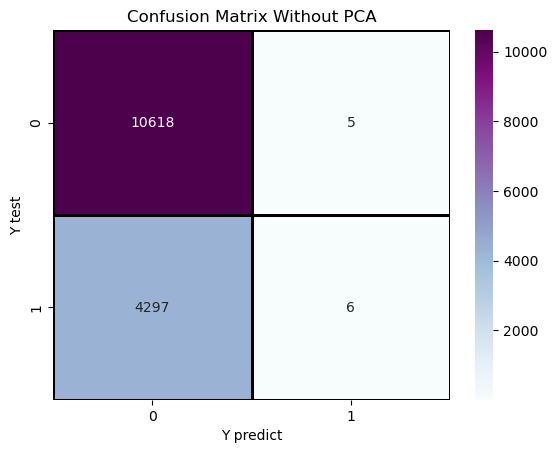

without pca AP:0.7117781053195765


In [34]:
# without pca
svm_cls = svm.SVC()
svm_cls.fit(X_train, y_train)
y_scores = svm_cls.predict(X_test)
naive_AP = svm_cls.score(X_test, y_test)
cm = confusion_matrix(y_test, y_scores)
f, ax = plt.subplots()
sns.heatmap(cm, annot=True, linewidth=0.75, linecolor='black', fmt='g', ax=ax, cmap="BuPu")
plt.title('Confusion Matrix Without PCA')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()
print('without pca AP:{}'.format(naive_AP))

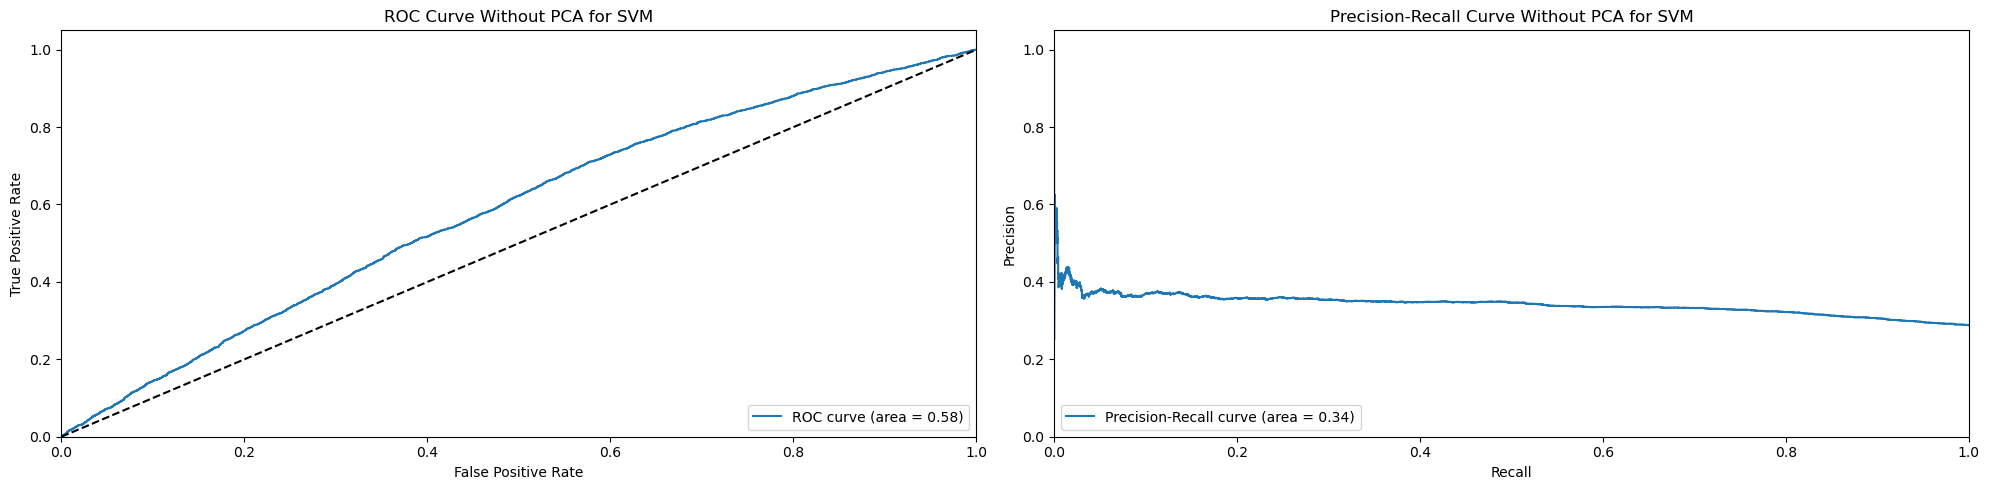

Without PCA AP: 0.71


In [35]:

svm_calibrated_naive = CalibratedClassifierCV(svm_cls, cv='prefit')
svm_calibrated_naive.fit(X_train, y_train)


y_scores_naive = svm_calibrated_naive.predict_proba(X_test)[:, 1]


fpr_naive, tpr_naive, _ = roc_curve(y_test, y_scores_naive)
roc_auc_naive = auc(fpr_naive, tpr_naive)


precision_naive, recall_naive, _ = precision_recall_curve(y_test, y_scores_naive)
average_precision_naive = average_precision_score(y_test, y_scores_naive)

plt.figure(figsize=(20, 5))  


plt.subplot(1, 2, 1)  
plt.plot(fpr_naive, tpr_naive, label='ROC curve (area = %0.2f)' % roc_auc_naive)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Without PCA for SVM')
plt.legend(loc="lower right")


plt.subplot(1, 2, 2)  
plt.plot(recall_naive, precision_naive, label='Precision-Recall curve (area = %0.2f)' % average_precision_naive)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve Without PCA for SVM')
plt.legend(loc="lower left")


plt.tight_layout()
plt.show()


print('Without PCA AP: {:.2f}'.format(naive_AP))

Results show that without PCA, svm classifier has 0.4% accuracy lower than the one use PCA form